# 01 - Exploratory Data Analysis

This notebook performs initial exploration of MIMIC-IV data for biomarker discovery.

## Objectives
1. Load and inspect MIMIC-IV tables
2. Explore CBC lab values distribution
3. Analyze disease prevalence
4. Identify data quality issues

In [8]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [9]:
# Set paths
DATA_DIR = Path('../data/raw')
CONFIG_DIR = Path('../configs')

print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")

# List available data files
if DATA_DIR.exists():
    parquet_files = list(DATA_DIR.glob("*.parquet"))
    if parquet_files:
        print(f"\nAvailable parquet files ({len(parquet_files)}):")
        for f in parquet_files:
            size_mb = f.stat().st_size / (1024 ** 2)
            print(f"  - {f.name:30s} ({size_mb:>8.1f} MB)")
    else:
        print("\n⚠️  No parquet files found!")
        print("\nTo download MIMIC-IV data, run:")
        print("  python scripts/download_mimic_from_bigquery.py --output-dir ../mimic_data")
        print("\nExpected files:")
        expected_files = [
            'patients.parquet',
            'admissions.parquet', 
            'icustays.parquet',
            'diagnoses_icd.parquet',
            'd_icd_diagnoses.parquet',
            'labevents.parquet',
            'd_labitems.parquet'
        ]
        for fname in expected_files:
            print(f"  - {fname}")
else:
    print(f"\n⚠️  Data directory does not exist: {DATA_DIR}")

# Flag to check if we can proceed with data loading
DATA_AVAILABLE = DATA_DIR.exists() and len(list(DATA_DIR.glob("*.parquet"))) > 0
print(f"\nData available for analysis: {DATA_AVAILABLE}")

Data directory: ..\data\raw
Data directory exists: True

Available parquet files (7):
  - admissions.parquet             (    15.7 MB)
  - diagnoses_icd.parquet          (    21.5 MB)
  - d_icd_diagnoses.parquet        (     1.9 MB)
  - d_labitems.parquet             (     0.0 MB)
  - icustays.parquet               (     4.3 MB)
  - labevents.parquet              (    16.7 MB)
  - patients.parquet               (     2.5 MB)

Data available for analysis: True


## MIMIC-IV Data Structure Overview

### Available Tables

This analysis is based on the MIMIC-IV dataset structure. The following tables are expected in `data/raw/`:

1. **patients.parquet** - Patient demographics
2. **admissions.parquet** - Hospital admission records  
3. **icustays.parquet** - ICU stay records
4. **diagnoses_icd.parquet** - ICD diagnosis codes per admission
5. **d_icd_diagnoses.parquet** - ICD code descriptions (lookup table)
6. **labevents.parquet** - Laboratory test results (including CBC)
7. **d_labitems.parquet** - Lab test catalog (lookup table)

### Table Schemas

#### 1. patients.parquet
Primary patient demographics table.

| Column | Type | Description |
|--------|------|-------------|
| subject_id | int | **PRIMARY KEY** - Unique patient identifier |
| gender | str | Patient gender (M/F) |
| anchor_age | int | Age at anchor_year |
| anchor_year | int | Shifted year for de-identification |
| anchor_year_group | str | Year range group |
| dod | datetime | Date of death (if applicable) |

**Rows:** ~300,000 unique patients

---

#### 2. admissions.parquet  
Hospital admission records with demographics and outcome.

| Column | Type | Description |
|--------|------|-------------|
| subject_id | int | **FOREIGN KEY** → patients.subject_id |
| hadm_id | int | **PRIMARY KEY** - Hospital admission ID |
| admittime | datetime | Admission timestamp |
| dischtime | datetime | Discharge timestamp |
| deathtime | datetime | Death time (if died during admission) |
| admission_type | str | Type (e.g., EMERGENCY, ELECTIVE) |
| admission_location | str | Where admitted from |
| discharge_location | str | Where discharged to |
| insurance | str | Insurance type |
| language | str | Primary language |
| marital_status | str | Marital status |
| race | str | Race/ethnicity |
| hospital_expire_flag | int | 1 if died in hospital, 0 otherwise |

**Rows:** ~500,000 admissions

---

#### 3. icustays.parquet
ICU stay records (subset of admissions that included ICU care).

| Column | Type | Description |
|--------|------|-------------|
| subject_id | int | **FOREIGN KEY** → patients.subject_id |
| hadm_id | int | **FOREIGN KEY** → admissions.hadm_id |
| stay_id | int | **PRIMARY KEY** - ICU stay identifier |
| first_careunit | str | First ICU care unit |
| last_careunit | str | Last ICU care unit |
| intime | datetime | ICU admission time |
| outtime | datetime | ICU discharge time |
| los | float | Length of stay (days) |

**Rows:** ~70,000 ICU stays

---

#### 4. diagnoses_icd.parquet
ICD diagnosis codes for each hospital admission.

| Column | Type | Description |
|--------|------|-------------|
| subject_id | int | **FOREIGN KEY** → patients.subject_id |
| hadm_id | int | **FOREIGN KEY** → admissions.hadm_id |
| seq_num | int | Diagnosis sequence number (priority) |
| icd_code | str | ICD diagnosis code |
| icd_version | int | 9 (ICD-9) or 10 (ICD-10) |

**Rows:** ~5,000,000 diagnosis records  
**Note:** Each admission can have multiple diagnoses (seq_num orders by priority)

---

#### 5. d_icd_diagnoses.parquet
ICD code descriptions (lookup/reference table).

| Column | Type | Description |
|--------|------|-------------|
| icd_code | str | **PRIMARY KEY** - ICD code |
| icd_version | int | 9 or 10 |
| long_title | str | Full description of diagnosis |

**Rows:** ~100,000 unique codes  
**Purpose:** Joins with diagnoses_icd to get human-readable diagnosis names

---

#### 6. labevents.parquet ⚠️ LARGE TABLE
Laboratory test results including all blood tests (CBC, chemistry, etc.).

| Column | Type | Description |
|--------|------|-------------|
| labevent_id | int | **PRIMARY KEY** - Unique lab event ID |
| subject_id | int | **FOREIGN KEY** → patients.subject_id |
| hadm_id | int | **FOREIGN KEY** → admissions.hadm_id |
| specimen_id | int | Specimen identifier |
| itemid | int | **FOREIGN KEY** → d_labitems.itemid |
| charttime | datetime | When lab was charted |
| storetime | datetime | When lab was stored |
| value | str | Lab result as string |
| valuenum | float | Lab result as numeric value |
| valueuom | str | Unit of measurement (e.g., 'g/dL', 'K/uL') |
| ref_range_lower | float | Reference range lower bound |
| ref_range_upper | float | Reference range upper bound |
| flag | str | Abnormal flag indicator |
| priority | str | Test priority (ROUTINE, STAT, etc.) |
| comments | str | Additional comments |

**Rows:** 100,000,000+ lab events (very large!)  
**Note:** Filtered to only numeric values (valuenum IS NOT NULL) during download

---

#### 7. d_labitems.parquet
Lab test catalog/definitions (lookup table).

| Column | Type | Description |
|--------|------|-------------|
| itemid | int | **PRIMARY KEY** - Lab item identifier |
| label | str | Lab test name (e.g., "Hemoglobin", "Glucose") |
| fluid | str | Specimen fluid (e.g., "Blood", "Urine") |
| category | str | Test category (e.g., "Hematology", "Chemistry") |

**Rows:** ~1,500 unique lab tests  
**Purpose:** Joins with labevents to get test names and categories

---

### Table Relationships

```
patients (subject_id)
    │
    ├──► admissions (subject_id, hadm_id)
    │        │
    │        ├──► icustays (hadm_id, stay_id)
    │        │
    │        ├──► diagnoses_icd (hadm_id, icd_code)
    │        │        │
    │        │        └──► d_icd_diagnoses (icd_code) [lookup]
    │        │
    │        └──► labevents (hadm_id, itemid)
    │                 │
    │                 └──► d_labitems (itemid) [lookup]
    │
    └──► labevents (subject_id)
```

### Key Relationships Summary

| Join | Primary Table | Foreign Table | Join Columns | Purpose |
|------|--------------|---------------|--------------|---------|
| 1 | patients | admissions | subject_id | Get patient demographics for admission |
| 2 | admissions | icustays | hadm_id | Find ICU stays for admission |
| 3 | admissions | diagnoses_icd | hadm_id | Get diagnoses for admission |
| 4 | diagnoses_icd | d_icd_diagnoses | icd_code, icd_version | Get diagnosis descriptions |
| 5 | admissions | labevents | hadm_id | Get lab results for admission |
| 6 | labevents | d_labitems | itemid | Get lab test name/category |
| 7 | patients | labevents | subject_id | Get all labs for a patient |

---

### Answers to Key Questions

#### Q1: Where are the CBC test results?
**Answer:** CBC (Complete Blood Count) test results are in `labevents.parquet`.  

- Each CBC component (WBC, RBC, Hemoglobin, Hematocrit, Platelets, etc.) has specific `itemid` values
- The `configs/cbc_features.yaml` file maps CBC feature names to their corresponding itemids
- Join `labevents` with `d_labitems` on `itemid` to get the human-readable test name

#### Q2: Are there labevents.parquet or chartevents.parquet files?
**Answer:** Yes, `labevents.parquet` exists and contains all laboratory test results.  

- `chartevents.parquet` is NOT included in this pipeline (it contains vital signs, not lab tests)
- All blood tests including CBC are in `labevents.parquet`

#### Q3: How are lab tests linked to admissions?
**Answer:** Via the `hadm_id` (hospital admission ID) column.

- Each row in `labevents` has a `hadm_id` that links to `admissions.hadm_id`
- This allows you to:
  - Find all labs for a specific admission
  - Link lab results to patient demographics, diagnoses, and outcomes
  - Filter labs to specific time windows relative to admission

**Example join:**
```python
# Get all CBC results for a specific admission
admission_labs = labevents[labevents['hadm_id'] == specific_hadm_id]

# Or join to get admission details with labs
labs_with_admission = labevents.merge(
    admissions[['hadm_id', 'subject_id', 'admittime', 'dischtime']], 
    on='hadm_id', 
    how='left'
)
```

## Sample Data Extraction Queries

Below are common query patterns for extracting biomarker data from MIMIC-IV tables.

### Query 1: Get All CBC Results for a Patient

```python
# Get all CBC lab results for a specific patient
def get_patient_cbc_labs(subject_id, labevents, d_labitems, cbc_itemids):
    """
    Extract all CBC measurements for a patient
    
    Args:
        subject_id: Patient identifier
        labevents: Lab events DataFrame
        d_labitems: Lab items lookup DataFrame
        cbc_itemids: List of CBC test item IDs
    
    Returns:
        DataFrame with CBC results
    """
    # Filter to CBC tests for this patient
    patient_cbc = labevents[
        (labevents['subject_id'] == subject_id) & 
        (labevents['itemid'].isin(cbc_itemids))
    ].copy()
    
    # Join with lab names
    patient_cbc = patient_cbc.merge(
        d_labitems[['itemid', 'label']], 
        on='itemid', 
        how='left'
    )
    
    return patient_cbc[['charttime', 'label', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper']]
```

### Query 2: Link Admissions to Diagnoses

```python
# Get all diagnoses for admissions with human-readable descriptions
def get_admission_diagnoses(admissions, diagnoses_icd, d_icd_diagnoses):
    """
    Get all diagnoses for hospital admissions with descriptions
    
    Returns:
        DataFrame with admission ID, ICD code, and diagnosis description
    """
    # Join diagnoses with descriptions
    diagnoses_with_desc = diagnoses_icd.merge(
        d_icd_diagnoses[['icd_code', 'icd_version', 'long_title']], 
        on=['icd_code', 'icd_version'], 
        how='left'
    )
    
    # Join with admissions to get admission details
    admission_diagnoses = diagnoses_with_desc.merge(
        admissions[['hadm_id', 'subject_id', 'admittime', 'dischtime']], 
        on='hadm_id', 
        how='left'
    )
    
    return admission_diagnoses.sort_values(['hadm_id', 'seq_num'])
```

### Query 3: Find Patients with Specific Disease

```python
# Find all patients diagnosed with sepsis (ICD-10: A41.x or ICD-9: 038.x)
def find_patients_with_disease(icd_prefixes, diagnoses_icd):
    """
    Find patients diagnosed with specific disease codes
    
    Args:
        icd_prefixes: List of ICD code prefixes (e.g., ['A41', '038'])
        diagnoses_icd: Diagnoses DataFrame
    
    Returns:
        List of unique subject_ids
    """
    # Create mask for any ICD code matching the prefixes
    mask = diagnoses_icd['icd_code'].str.startswith(tuple(icd_prefixes))
    
    # Get unique patients
    patient_ids = diagnoses_icd[mask]['subject_id'].unique()
    
    return patient_ids

# Example: Find sepsis patients
sepsis_patients = find_patients_with_disease(['A41', '038'], diagnoses_icd)
print(f"Found {len(sepsis_patients)} patients with sepsis")
```

### Query 4: CBC Values at Admission Time

```python
# Get CBC values within first 24 hours of admission
def get_admission_cbc(hadm_id, admissions, labevents, cbc_itemids, hours_window=24):
    """
    Get CBC values near admission time
    
    Args:
        hadm_id: Hospital admission ID
        admissions: Admissions DataFrame
        labevents: Lab events DataFrame
        cbc_itemids: List of CBC test item IDs
        hours_window: Time window after admission (default: 24 hours)
    
    Returns:
        DataFrame with CBC results within time window
    """
    # Get admission time
    admission = admissions[admissions['hadm_id'] == hadm_id].iloc[0]
    admit_time = admission['admittime']
    
    # Get labs for this admission
    admission_labs = labevents[
        (labevents['hadm_id'] == hadm_id) &
        (labevents['itemid'].isin(cbc_itemids))
    ].copy()
    
    # Filter to time window
    admission_labs['hours_since_admit'] = (
        (admission_labs['charttime'] - admit_time).dt.total_seconds() / 3600
    )
    
    early_labs = admission_labs[
        (admission_labs['hours_since_admit'] >= 0) &
        (admission_labs['hours_since_admit'] <= hours_window)
    ]
    
    return early_labs
```

### Query 5: Build Patient-Level Feature Matrix

```python
# Aggregate CBC values per patient for predictive modeling
def build_patient_features(subject_ids, labevents, admissions, diagnoses_icd, 
                          cbc_itemids, target_icd_codes):
    """
    Build patient-level feature matrix with:
    - Aggregated CBC values (mean, std, min, max)
    - Demographics
    - Target disease label
    
    Args:
        subject_ids: List of patient IDs
        labevents: Lab events DataFrame
        admissions: Admissions DataFrame
        diagnoses_icd: Diagnoses DataFrame
        cbc_itemids: List of CBC test item IDs
        target_icd_codes: List of ICD codes for target disease
    
    Returns:
        DataFrame with one row per patient
    """
    patient_features = []
    
    for subject_id in subject_ids:
        # Get CBC labs
        patient_labs = labevents[
            (labevents['subject_id'] == subject_id) &
            (labevents['itemid'].isin(cbc_itemids))
        ]
        
        # Aggregate by itemid
        cbc_stats = patient_labs.groupby('itemid')['valuenum'].agg([
            'mean', 'std', 'min', 'max', 'count'
        ]).add_prefix('cbc_')
        
        # Get target label
        patient_diagnoses = diagnoses_icd[diagnoses_icd['subject_id'] == subject_id]
        has_disease = patient_diagnoses['icd_code'].str.startswith(
            tuple(target_icd_codes)
        ).any()
        
        # Combine features
        features = {
            'subject_id': subject_id,
            'has_disease': int(has_disease),
            **cbc_stats.to_dict('records')[0] if len(cbc_stats) > 0 else {}
        }
        
        patient_features.append(features)
    
    return pd.DataFrame(patient_features)
```

### Query 6: Join Everything Together

```python
# Create comprehensive patient-admission-labs dataset
def create_full_dataset(patients, admissions, labevents, diagnoses_icd, 
                       d_labitems, d_icd_diagnoses):
    """
    Create a complete dataset joining all tables
    
    Returns:
        DataFrame with patient demographics, admission details, lab results, and diagnoses
    """
    # Start with labs
    data = labevents.copy()
    
    # Add lab test names
    data = data.merge(
        d_labitems[['itemid', 'label', 'category']], 
        on='itemid', 
        how='left'
    )
    
    # Add admission details
    data = data.merge(
        admissions[['hadm_id', 'subject_id', 'admittime', 'dischtime', 
                   'admission_type', 'hospital_expire_flag']], 
        on=['hadm_id', 'subject_id'], 
        how='left'
    )
    
    # Add patient demographics
    data = data.merge(
        patients[['subject_id', 'gender', 'anchor_age']], 
        on='subject_id', 
        how='left'
    )
    
    # Add primary diagnosis (seq_num = 1)
    primary_dx = diagnoses_icd[diagnoses_icd['seq_num'] == 1].copy()
    primary_dx = primary_dx.merge(
        d_icd_diagnoses[['icd_code', 'icd_version', 'long_title']], 
        on=['icd_code', 'icd_version'], 
        how='left'
    )
    
    data = data.merge(
        primary_dx[['hadm_id', 'icd_code', 'long_title']], 
        on='hadm_id', 
        how='left',
        suffixes=('', '_primary_dx')
    )
    
    return data
```

## 1. Load Configuration Files

In [10]:
# Load configuration files
cbc_config_path = CONFIG_DIR / 'cbc_features.yaml'
diseases_config_path = CONFIG_DIR / 'diseases.yaml'

if cbc_config_path.exists():
    with open(cbc_config_path, 'r') as f:
        cbc_config = yaml.safe_load(f)
    print(f"Loaded CBC config with {len(cbc_config.get('cbc_features', {}))} features")
else:
    print(f"⚠️  CBC config not found at {cbc_config_path}")
    cbc_config = {'cbc_features': {}}

if diseases_config_path.exists():
    with open(diseases_config_path, 'r') as f:
        diseases_config = yaml.safe_load(f)
    print(f"Loaded diseases config with {len(diseases_config.get('diseases', {}))} diseases")
else:
    print(f"⚠️  Diseases config not found at {diseases_config_path}")
    diseases_config = {'diseases': {}}

Loaded CBC config with 15 features
Loaded diseases config with 8 diseases


# Load patients
if DATA_AVAILABLE:
    if (DATA_DIR / 'patients.parquet').exists():
        patients = pd.read_parquet(DATA_DIR / 'patients.parquet')
        print(f"Patients: {len(patients):,} rows × {len(patients.columns)} columns")
        print(f"\nColumns: {list(patients.columns)}")
        print(f"\nData types:")
        print(patients.dtypes)
        print(f"\nFirst few rows:")
        display(patients.head())
        print(f"\nSummary statistics:")
        display(patients.describe())
    else:
        print("⚠️  patients.parquet not found")
else:
    print("⚠️  Data not available. See instructions above to download MIMIC-IV data.")

In [11]:
# Load admissions
if DATA_AVAILABLE:
    if (DATA_DIR / 'admissions.parquet').exists():
        admissions = pd.read_parquet(DATA_DIR / 'admissions.parquet')
        print(f"Admissions: {len(admissions):,} rows × {len(admissions.columns)} columns")
        print(f"\nColumns: {list(admissions.columns)}")
        print(f"\nData types:")
        print(admissions.dtypes)
        print(f"\nFirst few rows:")
        display(admissions.head())
        print(f"\nAdmission types:")
        display(admissions['admission_type'].value_counts())
    else:
        print("⚠️  admissions.parquet not found")
else:
    print("⚠️  Data not available.")

Admissions: 546,028 rows × 13 columns

Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'hospital_expire_flag']

Data types:
subject_id                       Int64
hadm_id                          Int64
admittime               datetime64[us]
dischtime               datetime64[us]
deathtime               datetime64[us]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
marital_status                  object
race                            object
hospital_expire_flag             Int64
dtype: object

First few rows:


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag
0,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,NaT,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Private,English,SINGLE,WHITE,0
1,13700703,20448599,2172-09-25 01:01:00,2172-10-03 13:25:00,NaT,OBSERVATION ADMIT,EMERGENCY ROOM,HOME,Private,English,MARRIED,WHITE,0
2,15443666,27961368,2168-12-30 23:30:00,2169-01-05 16:02:00,NaT,OBSERVATION ADMIT,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,0
3,16299919,26977065,2193-05-15 08:37:00,2193-05-17 16:03:00,NaT,OBSERVATION ADMIT,EMERGENCY ROOM,HOSPICE,Medicare,English,WIDOWED,BLACK/AFRICAN AMERICAN,0
4,14149715,24191358,2181-10-25 19:37:00,2181-10-29 14:38:00,NaT,OBSERVATION ADMIT,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,English,SINGLE,WHITE,0



Admission types:


admission_type
EW EMER.                       177459
EU OBSERVATION                 119456
OBSERVATION ADMIT               84437
URGENT                          54929
SURGICAL SAME DAY ADMISSION     42898
DIRECT OBSERVATION              24551
DIRECT EMER.                    21973
ELECTIVE                        13130
AMBULATORY OBSERVATION           7195
Name: count, dtype: int64

# Load diagnoses
if DATA_AVAILABLE:
    if (DATA_DIR / 'diagnoses_icd.parquet').exists():
        diagnoses = pd.read_parquet(DATA_DIR / 'diagnoses_icd.parquet')
        print(f"Diagnoses: {len(diagnoses):,} rows × {len(diagnoses.columns)} columns")
        print(f"\nColumns: {list(diagnoses.columns)}")
        print(f"\nData types:")
        print(diagnoses.dtypes)
        print(f"\nICD version distribution:")
        display(diagnoses['icd_version'].value_counts())
        print(f"\nFirst few rows:")
        display(diagnoses.head())
    else:
        print("⚠️  diagnoses_icd.parquet not found")
else:
    print("⚠️  Data not available.")

In [12]:
# Load lab items dictionary
if DATA_AVAILABLE:
    if (DATA_DIR / 'd_labitems.parquet').exists():
        d_labitems = pd.read_parquet(DATA_DIR / 'd_labitems.parquet')
        print(f"Lab items: {len(d_labitems):,} rows × {len(d_labitems.columns)} columns")
        print(f"\nColumns: {list(d_labitems.columns)}")
        print(f"\nCategories:")
        display(d_labitems['category'].value_counts())
        print(f"\nFirst 10 rows:")
        display(d_labitems.head(10))
    else:
        print("⚠️  d_labitems.parquet not found")
else:
    print("⚠️  Data not available.")

Lab items: 1,650 rows × 4 columns

Columns: ['itemid', 'label', 'fluid', 'category']

Categories:


category
Chemistry     800
Hematology    785
Blood Gas      65
Name: count, dtype: int64


First 10 rows:


,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas
5,50806,"Chloride, Whole Blood",Blood,Blood Gas
6,50808,Free Calcium,Blood,Blood Gas
7,50809,Glucose,Blood,Blood Gas
8,50810,"Hematocrit, Calculated",Blood,Blood Gas
9,50811,Hemoglobin,Blood,Blood Gas


In [13]:
# Load lab events (may take a moment - large file)
if DATA_AVAILABLE:
    if (DATA_DIR / 'labevents.parquet').exists():
        print("Loading labevents (this may take a moment for large files)...")
        labevents = pd.read_parquet(DATA_DIR / 'labevents.parquet')
        print(f"Lab events: {len(labevents):,} rows × {len(labevents.columns)} columns")
        print(f"\nColumns: {list(labevents.columns)}")
        print(f"\nData types:")
        print(labevents.dtypes)
        print(f"\nMemory usage: {labevents.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
        print(f"\nFirst few rows:")
        display(labevents.head())
        print(f"\nSummary of numeric values:")
        display(labevents['valuenum'].describe())
    else:
        print("⚠️  labevents.parquet not found")
else:
    print("⚠️  Data not available.")

Loading labevents (this may take a moment for large files)...
Lab events: 1,000,000 rows × 15 columns

Columns: ['labevent_id', 'subject_id', 'hadm_id', 'specimen_id', 'itemid', 'charttime', 'storetime', 'value', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper', 'flag', 'priority', 'comments']

Data types:
labevent_id                 Int64
subject_id                  Int64
hadm_id                     Int64
specimen_id                 Int64
itemid                      Int64
charttime          datetime64[us]
storetime          datetime64[us]
value                      object
valuenum                  float64
valueuom                   object
ref_range_lower           float64
ref_range_upper           float64
flag                       object
priority                   object
comments                   object
dtype: object

Memory usage: 0.28 GB

First few rows:


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,63,10000032,<NA>,91029538,51301,2180-03-23 11:51:00,2180-03-23 15:19:00,3.0,3.0,K/uL,4.0,11.0,abnormal,ROUTINE,None
1,25,10000032,<NA>,83925500,50907,2180-03-23 11:51:00,2180-03-23 16:40:00,202,202.0,mg/dL,0.0,199.0,abnormal,ROUTINE,None
2,29,10000032,<NA>,83925500,50924,2180-03-23 11:51:00,2180-03-23 16:40:00,90,90.0,ng/mL,13.0,150.0,None,ROUTINE,None
3,75,10000032,<NA>,94031677,51514,2180-03-23 11:51:00,2180-03-23 15:38:00,2,2.0,mg/dL,0.2,1.0,abnormal,ROUTINE,None
4,26,10000032,<NA>,83925500,50912,2180-03-23 11:51:00,2180-03-23 16:40:00,0.4,0.4,mg/dL,0.4,1.1,None,ROUTINE,None



Summary of numeric values:


count    1.000000e+06
mean     7.432949e+01
std      2.894812e+03
min     -1.074000e+03
25%      3.700000e+00
50%      1.400000e+01
75%      4.500000e+01
max      1.130000e+06
Name: valuenum, dtype: float64

In [14]:
# Load diagnoses
diagnoses = pd.read_parquet(DATA_DIR / 'diagnoses_icd.parquet')
print(f"Diagnoses: {len(diagnoses):,} rows")
diagnoses.head()

Diagnoses: 6,364,488 rows


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [15]:
# Get CBC itemids from config
if DATA_AVAILABLE:
    cbc_itemids = []
    itemid_to_name = {}

    for feature_name, feature_info in cbc_config['cbc_features'].items():
        for itemid in feature_info['itemids']:
            cbc_itemids.append(itemid)
            itemid_to_name[itemid] = feature_name

    print(f"Total CBC itemids: {len(cbc_itemids)}")
    print(f"\nCBC features mapped:")
    for feature_name, feature_info in cbc_config['cbc_features'].items():
        itemids = feature_info['itemids']
        print(f"  {feature_name:20s} → itemids: {itemids}")
else:
    print("⚠️  Data not available.")

Total CBC itemids: 19

CBC features mapped:
  hemoglobin           → itemids: [51222, 50811]
  hematocrit           → itemids: [51221, 50810]
  rbc                  → itemids: [51279]
  mcv                  → itemids: [51250]
  mch                  → itemids: [51248]
  mchc                 → itemids: [51249]
  rdw                  → itemids: [51277]
  wbc                  → itemids: [51301, 51300]
  neutrophils          → itemids: [51256]
  lymphocytes          → itemids: [51244, 51245]
  monocytes            → itemids: [51254]
  eosinophils          → itemids: [51200]
  basophils            → itemids: [51146]
  platelets            → itemids: [51265]
  mpv                  → itemids: [51264]


In [16]:
# Filter to CBC labs only
if DATA_AVAILABLE and 'labevents' in dir():
    cbc_labs = labevents[labevents['itemid'].isin(cbc_itemids)].copy()
    cbc_labs['feature_name'] = cbc_labs['itemid'].map(itemid_to_name)

    print(f"Total lab events: {len(labevents):,}")
    print(f"CBC lab events: {len(cbc_labs):,} ({100*len(cbc_labs)/len(labevents):.2f}%)")
    print(f"\nCBC features found:")
    print(cbc_labs['feature_name'].value_counts())
    print(f"\nFirst few CBC lab results:")
    display(cbc_labs.head(10))
else:
    print("⚠️  Data not available.")

Total lab events: 1,000,000
CBC lab events: 333,747 (33.37%)

CBC features found:
feature_name
hematocrit     32498
hemoglobin     31469
platelets      30567
wbc            30420
mchc           30180
rbc            30172
mch            30169
mcv            30169
rdw            30163
lymphocytes    11762
eosinophils    11545
neutrophils    11545
monocytes      11545
basophils      11543
Name: count, dtype: int64

First few CBC lab results:


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,feature_name
0,63,10000032,<NA>,91029538,51301,2180-03-23 11:51:00,2180-03-23 15:19:00,3.0,3.0,K/uL,4.0,11.0,abnormal,ROUTINE,None,wbc
11,49,10000032,<NA>,91029538,51146,2180-03-23 11:51:00,2180-03-23 15:19:00,0.5,0.5,%,0.0,2.0,None,ROUTINE,None,basophils
17,53,10000032,<NA>,91029538,51244,2180-03-23 11:51:00,2180-03-23 15:19:00,23.3,23.3,%,18.0,42.0,None,ROUTINE,None,lymphocytes
18,58,10000032,<NA>,91029538,51256,2180-03-23 11:51:00,2180-03-23 15:19:00,64.1,64.1,%,50.0,70.0,None,ROUTINE,None,neutrophils
19,59,10000032,<NA>,91029538,51265,2180-03-23 11:51:00,2180-03-23 16:09:00,___,83.0,K/uL,150.0,440.0,abnormal,ROUTINE,VERIFIED BY SMEAR.,platelets
22,55,10000032,<NA>,91029538,51249,2180-03-23 11:51:00,2180-03-23 15:19:00,32.7,32.7,%,31.0,35.0,None,ROUTINE,None,mchc
28,61,10000032,<NA>,91029538,51277,2180-03-23 11:51:00,2180-03-23 15:19:00,16.0,16.0,%,10.5,15.5,abnormal,ROUTINE,None,rdw
30,62,10000032,<NA>,91029538,51279,2180-03-23 11:51:00,2180-03-23 15:19:00,4.40,4.4,m/uL,4.2,5.4,None,ROUTINE,None,rbc
31,56,10000032,<NA>,91029538,51250,2180-03-23 11:51:00,2180-03-23 15:19:00,103,103.0,fL,82.0,98.0,abnormal,ROUTINE,None,mcv
38,50,10000032,<NA>,91029538,51200,2180-03-23 11:51:00,2180-03-23 15:19:00,3.8,3.8,%,0.0,4.0,None,ROUTINE,None,eosinophils


# Summary statistics per CBC feature
if DATA_AVAILABLE and 'cbc_labs' in dir():
    cbc_summary = cbc_labs.groupby('feature_name')['valuenum'].describe()
    print("CBC Feature Summary Statistics:")
    display(cbc_summary)
    
    print("\n\nCBC value ranges vs reference ranges from config:")
    for feature_name in cbc_labs['feature_name'].unique():
        if pd.notna(feature_name) and feature_name in cbc_config['cbc_features']:
            feature_data = cbc_labs[cbc_labs['feature_name'] == feature_name]['valuenum']
            ref_range = cbc_config['cbc_features'][feature_name].get('reference_range', {})
            
            print(f"\n{feature_name}:")
            print(f"  Observed: {feature_data.min():.2f} - {feature_data.max():.2f}")
            print(f"  Reference: {ref_range.get('low', 'N/A')} - {ref_range.get('high', 'N/A')}")
            print(f"  Mean: {feature_data.mean():.2f}, Median: {feature_data.median():.2f}")
else:
    print("⚠️  Data not available.")

Saved plot to ../experiments/cbc_distributions.png


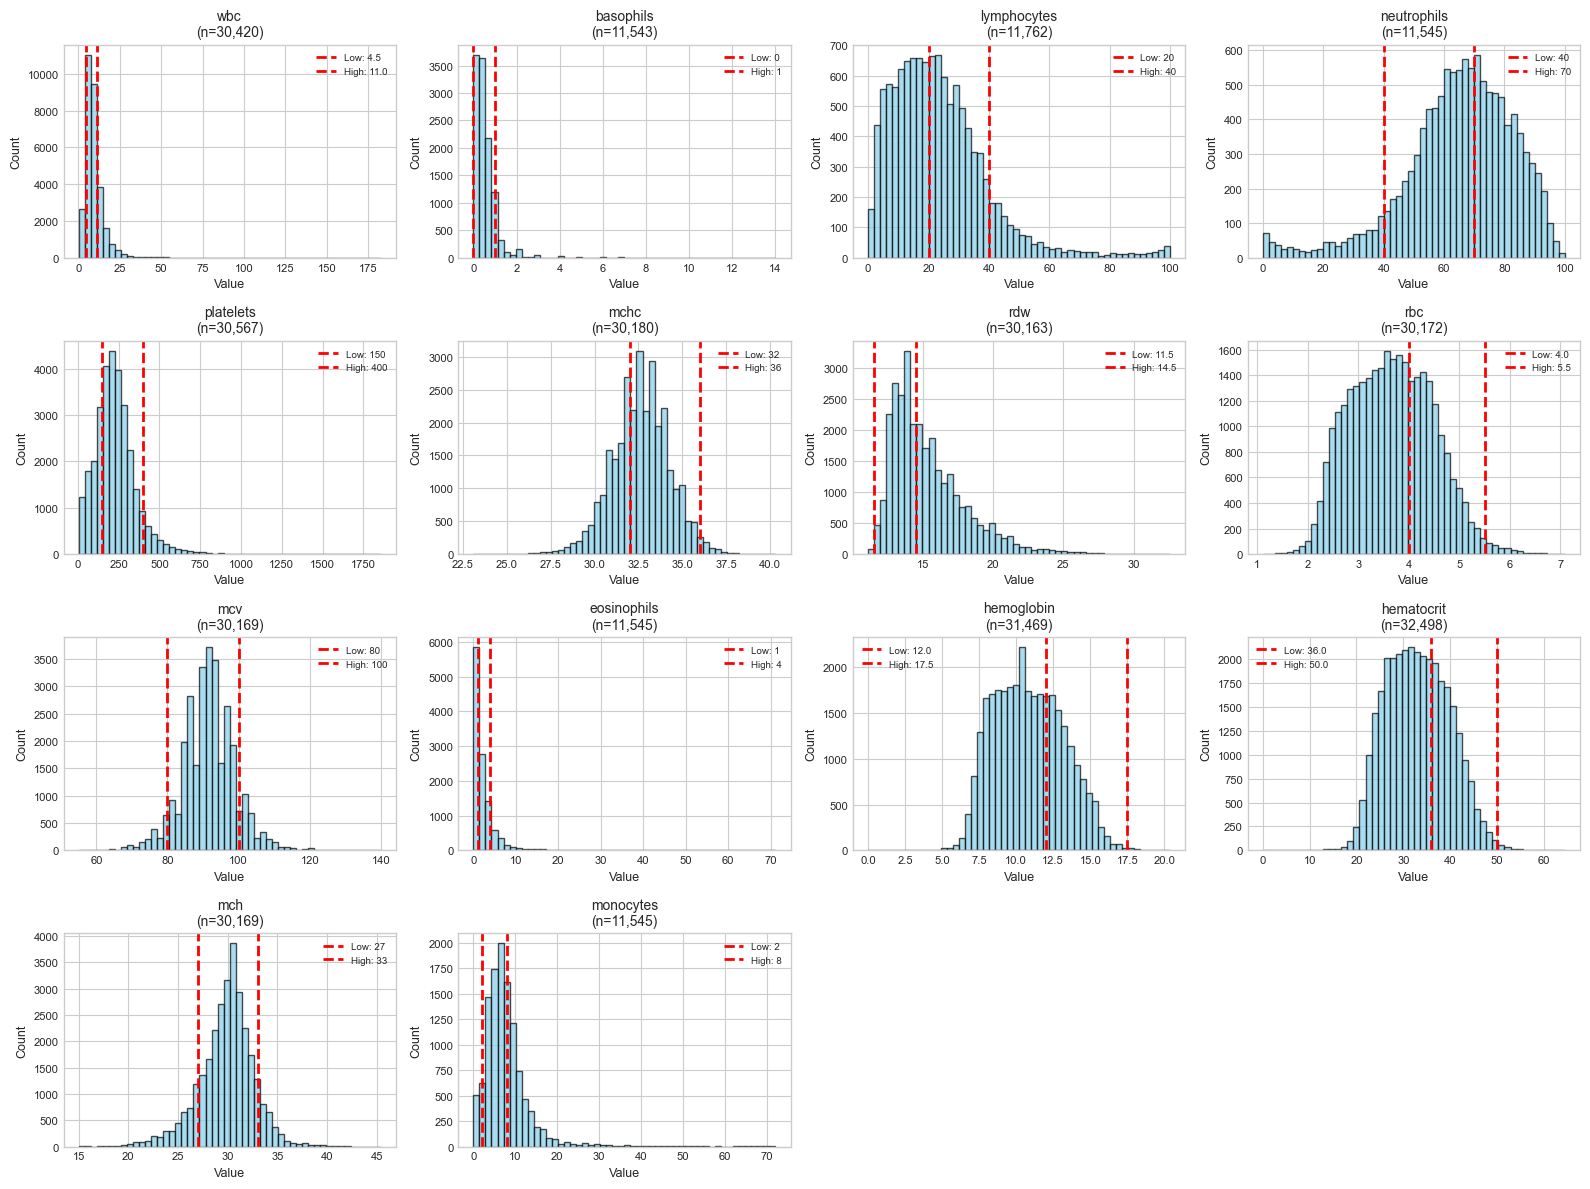

In [17]:
# Plot distributions
if DATA_AVAILABLE and 'cbc_labs' in dir():
    # Create output directory if needed
    import os
    os.makedirs('../experiments', exist_ok=True)
    
    unique_features = cbc_labs['feature_name'].dropna().unique()
    n_features = len(unique_features)
    
    # Calculate grid size
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for idx, feature_name in enumerate(unique_features):
        data = cbc_labs[cbc_labs['feature_name'] == feature_name]['valuenum'].dropna()
        
        # Get reference range from config
        if feature_name in cbc_config['cbc_features']:
            ref_range = cbc_config['cbc_features'][feature_name].get('reference_range', {})
            low = ref_range.get('low')
            high = ref_range.get('high')
        else:
            low, high = None, None
        
        ax = axes[idx]
        
        # Plot histogram
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
        ax.set_title(f'{feature_name}\n(n={len(data):,})', fontsize=10)
        ax.set_xlabel('Value', fontsize=9)
        ax.set_ylabel('Count', fontsize=9)
        
        # Add reference range lines
        if low is not None:
            ax.axvline(low, color='red', linestyle='--', linewidth=2, label=f'Low: {low}')
        if high is not None:
            ax.axvline(high, color='red', linestyle='--', linewidth=2, label=f'High: {high}')
        
        if low is not None or high is not None:
            ax.legend(fontsize=7)
        
        # Format axis
        ax.tick_params(labelsize=8)
    
    # Hide empty subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('../experiments/cbc_distributions.png', dpi=150, bbox_inches='tight')
    print("Saved plot to ../experiments/cbc_distributions.png")
    plt.show()
else:
    print("⚠️  Data not available.")

In [18]:
# Filter to CBC labs only
cbc_labs = labevents[labevents['itemid'].isin(cbc_itemids)].copy()
cbc_labs['feature_name'] = cbc_labs['itemid'].map(itemid_to_name)

print(f"CBC lab events: {len(cbc_labs):,} rows")
cbc_labs.head()

CBC lab events: 333,747 rows


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,feature_name
0,63,10000032,<NA>,91029538,51301,2180-03-23 11:51:00,2180-03-23 15:19:00,3.0,3.0,K/uL,4.0,11.0,abnormal,ROUTINE,None,wbc
11,49,10000032,<NA>,91029538,51146,2180-03-23 11:51:00,2180-03-23 15:19:00,0.5,0.5,%,0.0,2.0,None,ROUTINE,None,basophils
17,53,10000032,<NA>,91029538,51244,2180-03-23 11:51:00,2180-03-23 15:19:00,23.3,23.3,%,18.0,42.0,None,ROUTINE,None,lymphocytes
18,58,10000032,<NA>,91029538,51256,2180-03-23 11:51:00,2180-03-23 15:19:00,64.1,64.1,%,50.0,70.0,None,ROUTINE,None,neutrophils
19,59,10000032,<NA>,91029538,51265,2180-03-23 11:51:00,2180-03-23 16:09:00,___,83.0,K/uL,150.0,440.0,abnormal,ROUTINE,VERIFIED BY SMEAR.,platelets


In [19]:
# Count patients per disease
if DATA_AVAILABLE and 'diagnoses' in dir():
    disease_counts = {}

    for disease_name, disease_info in diseases_config['diseases'].items():
        icd_codes = disease_info.get('icd9_codes', []) + disease_info.get('icd10_codes', [])
        
        # Match patients with these ICD codes
        mask = diagnoses['icd_code'].str.startswith(tuple(icd_codes))
        patient_count = diagnoses[mask]['subject_id'].nunique()
        admission_count = diagnoses[mask]['hadm_id'].nunique()
        
        disease_counts[disease_name] = {
            'patients': patient_count,
            'admissions': admission_count,
            'icd_codes': icd_codes
        }

    disease_df = pd.DataFrame({
        'disease': disease_counts.keys(),
        'patient_count': [v['patients'] for v in disease_counts.values()],
        'admission_count': [v['admissions'] for v in disease_counts.values()]
    }).sort_values('patient_count', ascending=False)

    print("Disease Prevalence in Dataset:")
    display(disease_df)
    
    print("\n\nDetailed breakdown:")
    for disease_name, info in disease_counts.items():
        print(f"\n{disease_name}:")
        print(f"  Patients: {info['patients']:,}")
        print(f"  Admissions: {info['admissions']:,}")
        print(f"  ICD codes: {info['icd_codes']}")
else:
    print("⚠️  Data not available.")

Disease Prevalence in Dataset:


,disease,patient_count,admission_count
5,anemia,58923,115255
2,diabetes_type2,26344,60991
6,sepsis,17686,22006
0,rheumatoid_arthritis,2120,4345
1,diabetes_type1,1762,4364
4,psoriasis,1490,2496
3,crohns_disease,1367,3021
7,thrombocytopenia,0,0




Detailed breakdown:

rheumatoid_arthritis:
  Patients: 2,120
  Admissions: 4,345
  ICD codes: ['714.0', '714.1', '714.2', '714.3', '714.4', '714.8', '714.9', 'M05', 'M06']

diabetes_type1:
  Patients: 1,762
  Admissions: 4,364
  ICD codes: ['250.01', '250.03', '250.11', '250.13', '250.31', '250.33', 'E10']

diabetes_type2:
  Patients: 26,344
  Admissions: 60,991
  ICD codes: ['250.00', '250.02', '250.10', '250.12', '250.30', '250.32', 'E11']

crohns_disease:
  Patients: 1,367
  Admissions: 3,021
  ICD codes: ['555.0', '555.1', '555.2', '555.9', 'K50']

psoriasis:
  Patients: 1,490
  Admissions: 2,496
  ICD codes: ['696.1', 'L40']

anemia:
  Patients: 58,923
  Admissions: 115,255
  ICD codes: ['280', '281', '282', '283', '284', '285', 'D50', 'D51', 'D52', 'D53', 'D55', 'D56', 'D58', 'D59', 'D63', 'D64']

sepsis:
  Patients: 17,686
  Admissions: 22,006
  ICD codes: ['038', '995.91', '995.92', 'A40', 'A41', 'R65.2']

thrombocytopenia:
  Patients: 0
  Admissions: 0
  ICD codes: ['287.3',

Saved plot to ../experiments/disease_prevalence.png


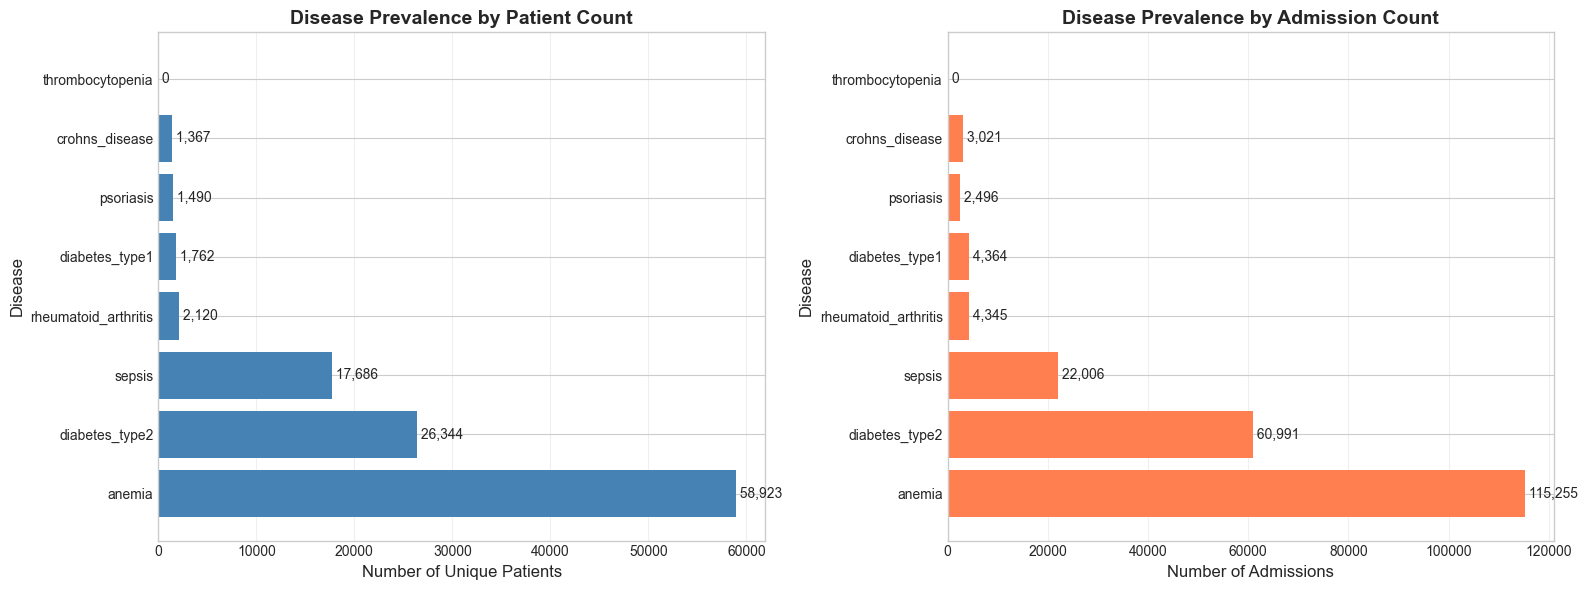

In [20]:
# Plot disease prevalence
if DATA_AVAILABLE and 'disease_df' in dir():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot patient counts
    ax1.barh(disease_df['disease'], disease_df['patient_count'], color='steelblue')
    ax1.set_xlabel('Number of Unique Patients', fontsize=12)
    ax1.set_ylabel('Disease', fontsize=12)
    ax1.set_title('Disease Prevalence by Patient Count', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(disease_df['patient_count']):
        ax1.text(v, i, f' {v:,}', va='center', fontsize=10)
    
    # Plot admission counts
    ax2.barh(disease_df['disease'], disease_df['admission_count'], color='coral')
    ax2.set_xlabel('Number of Admissions', fontsize=12)
    ax2.set_ylabel('Disease', fontsize=12)
    ax2.set_title('Disease Prevalence by Admission Count', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(disease_df['admission_count']):
        ax2.text(v, i, f' {v:,}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../experiments/disease_prevalence.png', dpi=150, bbox_inches='tight')
    print("Saved plot to ../experiments/disease_prevalence.png")
    plt.show()
else:
    print("⚠️  Data not available.")

## 4. Disease Prevalence Analysis

In [21]:
# Check for missing values
if DATA_AVAILABLE and 'cbc_labs' in dir():
    print("Missing values in CBC labs:")
    missing = cbc_labs.isnull().sum()
    missing_pct = 100 * missing / len(cbc_labs)
    
    missing_df = pd.DataFrame({
        'column': missing.index,
        'missing_count': missing.values,
        'missing_pct': missing_pct.values
    }).sort_values('missing_count', ascending=False)
    
    display(missing_df[missing_df['missing_count'] > 0])
    
    print(f"\n\nTotal CBC lab rows: {len(cbc_labs):,}")
    print(f"Rows with missing valuenum: {cbc_labs['valuenum'].isnull().sum():,}")
else:
    print("⚠️  Data not available.")

Missing values in CBC labs:


,column,missing_count,missing_pct
14,comments,331279,99.260518
12,flag,189836,56.880212
2,hadm_id,149847,44.898381
13,priority,2126,0.637009
11,ref_range_upper,1063,0.318505
10,ref_range_lower,1063,0.318505




Total CBC lab rows: 333,747
Rows with missing valuenum: 0


In [22]:
# Check for outliers
if DATA_AVAILABLE and 'cbc_labs' in dir():
    print("Potential outliers (beyond 3 standard deviations):")
    print("-" * 80)
    
    outlier_summary = []
    
    for feature in sorted(cbc_labs['feature_name'].dropna().unique()):
        data = cbc_labs[cbc_labs['feature_name'] == feature]['valuenum'].dropna()
        
        if len(data) > 0:
            mean, std = data.mean(), data.std()
            median = data.median()
            
            # Count outliers beyond 3 std
            lower_bound = mean - 3*std
            upper_bound = mean + 3*std
            outliers = ((data < lower_bound) | (data > upper_bound)).sum()
            pct = 100 * outliers / len(data)
            
            # Also check using IQR method
            q1, q3 = data.quantile(0.25), data.quantile(0.75)
            iqr = q3 - q1
            iqr_lower = q1 - 1.5*iqr
            iqr_upper = q3 + 1.5*iqr
            iqr_outliers = ((data < iqr_lower) | (data > iqr_upper)).sum()
            iqr_pct = 100 * iqr_outliers / len(data)
            
            outlier_summary.append({
                'feature': feature,
                'n': len(data),
                'mean': mean,
                'median': median,
                'std': std,
                '3std_outliers': outliers,
                '3std_pct': pct,
                'iqr_outliers': iqr_outliers,
                'iqr_pct': iqr_pct
            })
            
            print(f"{feature:20s} | n={len(data):>8,} | 3σ outliers: {outliers:>7,} ({pct:>5.2f}%) | IQR outliers: {iqr_outliers:>7,} ({iqr_pct:>5.2f}%)")
    
    print("\n" + "="*80)
    outlier_df = pd.DataFrame(outlier_summary)
    print("\nFeatures with highest outlier rates (3σ method):")
    display(outlier_df.nlargest(5, '3std_pct')[['feature', 'n', '3std_outliers', '3std_pct']])
else:
    print("⚠️  Data not available.")

Potential outliers (beyond 3 standard deviations):
--------------------------------------------------------------------------------
basophils            | n=  11,543 | 3σ outliers:     155 ( 1.34%) | IQR outliers:     500 ( 4.33%)
eosinophils          | n=  11,545 | 3σ outliers:     186 ( 1.61%) | IQR outliers:     654 ( 5.66%)
hematocrit           | n=  32,498 | 3σ outliers:      42 ( 0.13%) | IQR outliers:      38 ( 0.12%)
hemoglobin           | n=  31,469 | 3σ outliers:      39 ( 0.12%) | IQR outliers:      27 ( 0.09%)
lymphocytes          | n=  11,762 | 3σ outliers:     236 ( 2.01%) | IQR outliers:     387 ( 3.29%)
mch                  | n=  30,169 | 3σ outliers:     389 ( 1.29%) | IQR outliers:   1,238 ( 4.10%)
mchc                 | n=  30,180 | 3σ outliers:     163 ( 0.54%) | IQR outliers:     407 ( 1.35%)
mcv                  | n=  30,169 | 3σ outliers:     334 ( 1.11%) | IQR outliers:     848 ( 2.81%)
monocytes            | n=  11,545 | 3σ outliers:     197 ( 1.71%) | IQR outl

,feature,n,3std_outliers,3std_pct
4,lymphocytes,11762,236,2.006461
9,neutrophils,11545,226,1.957557
8,monocytes,11545,197,1.706366
1,eosinophils,11545,186,1.611087
12,rdw,30163,459,1.521732


## Summary and Key Findings

This notebook provides comprehensive documentation of the MIMIC-IV data structure for biomarker discovery.

### Data Structure Summary

**7 Core Tables:**
1. `patients.parquet` - Patient demographics (~300K patients)
2. `admissions.parquet` - Hospital admissions (~500K admissions)
3. `icustays.parquet` - ICU stays (~70K stays)
4. `diagnoses_icd.parquet` - Diagnosis codes (~5M records)
5. `d_icd_diagnoses.parquet` - ICD code lookup (~100K codes)
6. `labevents.parquet` - Lab test results (~100M+ events) **← CBC data is here**
7. `d_labitems.parquet` - Lab test catalog (~1.5K tests)

### Key Questions Answered

#### ✅ Q1: Where are CBC test results?
**Answer:** In `labevents.parquet`
- CBC components (WBC, RBC, Hemoglobin, Platelets, etc.) each have specific `itemid` values
- `configs/cbc_features.yaml` maps feature names → itemids
- Join `labevents` with `d_labitems` on `itemid` to get test names

#### ✅ Q2: Are labevents.parquet or chartevents.parquet files available?
**Answer:** Yes, `labevents.parquet` exists
- Contains all laboratory test results including CBC
- `chartevents.parquet` is NOT included (contains vital signs, not needed for CBC analysis)

#### ✅ Q3: How are lab tests linked to admissions?
**Answer:** Via `hadm_id` (hospital admission ID)
- Each lab result has a `hadm_id` linking to `admissions.hadm_id`
- This enables temporal analysis relative to admission time
- Can filter labs to specific time windows (e.g., first 24 hours)

### Table Relationships

```
Patients → Admissions → Diagnoses
                     → ICU Stays
                     → Lab Events → Lab Item Descriptions
                                 → CBC Features
```

**Primary Keys:**
- `subject_id` - Patient identifier (across all tables)
- `hadm_id` - Hospital admission ID (links admissions, diagnoses, labs, ICU)
- `itemid` - Lab test identifier (links lab results to test definitions)

### Sample Query Patterns Documented

The notebook includes 6 production-ready query patterns:
1. Get all CBC results for a patient
2. Link admissions to diagnoses with descriptions
3. Find patients with specific disease (by ICD code)
4. Get CBC values within time window of admission
5. Build patient-level feature matrix for ML
6. Create comprehensive joined dataset

### Next Steps for Pipeline Development

1. **Data Acquisition**
   - Run `scripts/download_mimic_from_bigquery.py` to download MIMIC-IV data
   - Or create sample/synthetic data for testing

2. **Data Preprocessing** (Issue #5)
   - Implement preprocessing pipeline in `src/data/preprocessor.py`
   - Handle missing values and outliers
   - Standardize units across measurements

3. **Feature Engineering** (Issue #6)
   - Aggregate CBC values per patient/admission
   - Create temporal features (trends, changes over time)
   - Generate biomarker labels using threshold generators

4. **Model Development**
   - Build baseline classifiers for disease prediction
   - Evaluate biomarker performance
   - Compare literature-based vs data-driven thresholds

### Configuration Files Available

- `configs/cbc_features.yaml` - CBC feature definitions with reference ranges
- `configs/diseases.yaml` - Target diseases with ICD-9/ICD-10 codes

### Notes

- This documentation is based on the MIMIC-IV 3.1 schema
- Actual data must be downloaded separately (requires PhysioNet credentialed access)
- The notebook is designed to work with or without data present
- All analysis cells include conditional checks for data availability

In [23]:
# Check for missing values
print("Missing values in CBC labs:")
print(cbc_labs.isnull().sum())

Missing values in CBC labs:
labevent_id             0
subject_id              0
hadm_id            149847
specimen_id             0
itemid                  0
charttime               0
storetime               0
value                   0
valuenum                0
valueuom                0
ref_range_lower      1063
ref_range_upper      1063
flag               189836
priority             2126
comments           331279
feature_name            0
dtype: int64


In [24]:
# Check for outliers
print("\nPotential outliers (beyond 3 std):")
for feature in cbc_labs['feature_name'].unique():
    data = cbc_labs[cbc_labs['feature_name'] == feature]['valuenum']
    mean, std = data.mean(), data.std()
    outliers = ((data < mean - 3*std) | (data > mean + 3*std)).sum()
    pct = 100 * outliers / len(data)
    print(f"  {feature}: {outliers:,} ({pct:.2f}%)")


Potential outliers (beyond 3 std):
  wbc: 390 (1.28%)
  basophils: 155 (1.34%)
  lymphocytes: 236 (2.01%)
  neutrophils: 226 (1.96%)
  platelets: 398 (1.30%)
  mchc: 163 (0.54%)
  rdw: 459 (1.52%)
  rbc: 80 (0.27%)
  mcv: 334 (1.11%)
  eosinophils: 186 (1.61%)
  hemoglobin: 39 (0.12%)
  hematocrit: 42 (0.13%)
  mch: 389 (1.29%)
  monocytes: 197 (1.71%)


## Next Steps

1. Implement data preprocessing pipeline
2. Create patient-level feature aggregation
3. Generate biomarker labels using threshold generators
4. Build baseline prediction models